In [11]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, applications, optimizers

In [ ]:
# 1. Configuration
CSV_PATH = "processed_dataset/videos_metadata.csv"
BATCH_SIZE = 8
IMG_SIZE = 128  
NUM_FRAMES = 30 

In [ ]:
# 2. Data Loading 
df = pd.read_csv(CSV_PATH)
df['file_path'] = df['file_path'].apply(lambda x: x.replace('\\', os.sep)) 

# Create Splits
train_df = df[df["split"] == "train"]
val_df   = df[df["split"] == "val"]
test_df  = df[df["split"] == "test"]

def load_npy_file(path, label):
    video = np.load(path.numpy().decode("utf-8")) 
    
    total_frames = video.shape[0]
    target_frames = 30
    
    if total_frames == target_frames:
        sampled_video = video
    else:
        indices = np.linspace(0, total_frames - 1, target_frames).astype(int)
        sampled_video = video[indices]
        
    return sampled_video.astype("float32"), np.int32(label)

def tf_load_npy(path, label):
    video, label = tf.py_function(load_npy_file, [path, label], [tf.float32, tf.int32])
    video.set_shape((NUM_FRAMES, 64, 64, 3))
    label.set_shape(())
    return video, label

# Dataset Builder
def build_dataset(dataframe, shuffle=True):
    paths = dataframe["file_path"].values
    labels = dataframe["label"].values
    
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(dataframe))
    
    ds = ds.map(tf_load_npy, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Create Datasets
train_ds = build_dataset(train_df, shuffle=True)
val_ds   = build_dataset(val_df, shuffle=False)
test_ds  = build_dataset(test_df, shuffle=False)

num_classes = df["label"].nunique()
print(f"Classes: {num_classes}")

Classes: 5


In [ ]:
# 3. Build Model
def build_mobilenet_transfer_model():
    inputs = layers.Input(shape=(30, 64, 64, 3))
    
    x = layers.TimeDistributed(layers.Resizing(128, 128))(inputs)
    
    x = layers.TimeDistributed(layers.Rescaling(2.0, offset=-1.0))(x)
    
    # 3. MobileNetV2 Base
    base_model = applications.MobileNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=(128, 128, 3),
        pooling='avg'
    )
    base_model.trainable = False 
    
    x = layers.TimeDistributed(base_model)(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return Model(inputs, outputs, name="MobileNetV2_Transfer")

model = build_mobilenet_transfer_model()
model.summary()

Model: "MobileNetV2_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 30, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 30, 128, 128,   │             0 │
│ (TimeDistributed)               │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 30, 128, 128,   │             0 │
│ (TimeDistributed)               │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 30, 1280)       │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
# 4. Train
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nStarting Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Starting Training...
Epoch 1/10


70/70 ━━━━━━━━━━━━━━━━━━━━ 628s 6s/step - accuracy: 0.3235 - loss: 1.7899 - val_accuracy: 0.6000 - val_loss: 0.9488
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 394s 5s/step - accuracy: 0.6497 - loss: 0.8971 - val_accuracy: 0.7217 - val_loss: 0.7115
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 534s 8s/step - accuracy: 0.7886 - loss: 0.6051 - val_accuracy: 0.7478 - val_loss: 0.6318
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 273s 4s/step - accuracy: 0.8504 - loss: 0.4582 - val_accuracy: 0.7391 - val_loss: 0.5855
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 329s 5s/step - accuracy: 0.8559 - loss: 0.4194 - val_accuracy: 0.7130 - val_loss: 0.6728
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.9133 - loss: 0.3156 - val_accuracy: 0.7043 - val_loss: 0.7310
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.8667 - loss: 0.3574 - val_accuracy: 0.7739 - val_loss: 0.5649
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.9538 - loss: 0.2070 - val_accuracy: 0.7826 - val_loss: 0.

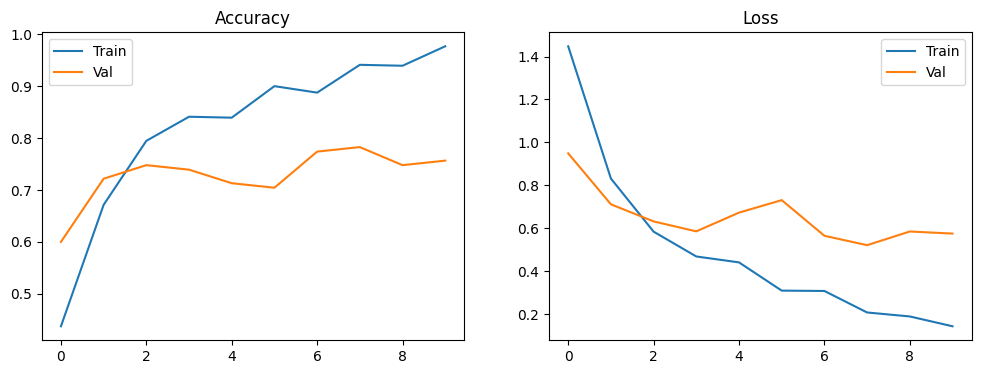


Final Test Evaluation:
15/15 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.6574 - loss: 0.7479
Test Accuracy: 63.48%


In [16]:
# 5. Evaluation & Graphs
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

# Final Test
print("\nFinal Test Evaluation:")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Generating predicted probabilities for ROC/AUC...

AUC (per class):
- Left_Swipe: 0.8563
- Right_Swipe: 0.9203
- Stop: 0.9310
- Thumbs_Down: 0.9730
- Thumbs_Up: 0.9397


C:\Users\rhmar\AppData\Local\Temp\ipykernel_11688\1409772812.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_classes)


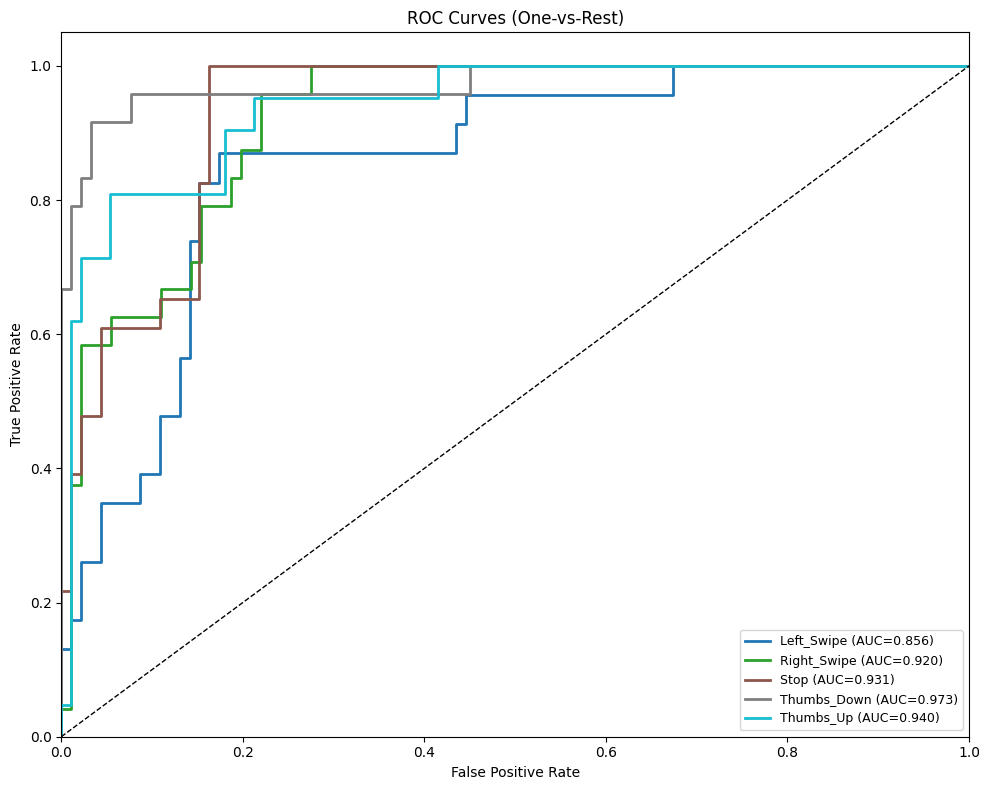

In [ ]:
# 6. ROC Curve + AUC (Test Set)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

print("Generating predicted probabilities for ROC/AUC...")

y_true = []
y_score = []  

for videos, labels in test_ds:
    probs = model.predict(videos, verbose=0)  # softmax probabilities
    y_true.extend(labels.numpy())
    y_score.append(probs)

y_true = np.array(y_true)
y_score = np.concatenate(y_score, axis=0) if len(y_score) else np.zeros((0, num_classes), dtype=np.float32)

label_to_name = (
    df[["label", "gesture"]]
    .drop_duplicates()
    .sort_values("label")
    .set_index("label")["gesture"]
    .to_dict()
)
class_names = [label_to_name[i] for i in range(num_classes)]

Y = label_binarize(y_true, classes=list(range(num_classes))) 

fpr, tpr, roc_auc = {}, {}, {}

# Per-class ROC + AUC
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


print("\nAUC (per class):")
for i, name in enumerate(class_names):
    print(f"- {name}: {roc_auc[i]:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))

colors = plt.cm.get_cmap("tab10", num_classes)
for i, name in enumerate(class_names):
    plt.plot(
        fpr[i],
        tpr[i],
        color=colors(i),
        linewidth=2,
        label=f"{name} (AUC={roc_auc[i]:.3f})",
    )

plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()